<a href="https://colab.research.google.com/github/rboghe/cened/blob/master/cened_merged_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TO DO



*   take care of _x and _y


# Load data

##Loading Files

In [1]:
import os
import urllib.request
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, make_scorer
from lightgbm import LGBMRegressor, plot_importance
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns

# Silence panda's setting with copy warning
pd.options.mode.chained_assignment = None

# Set Seaborn style
sns.set_theme(style="white")

In [2]:
url = 'https://www.dati.lombardia.it/api/views/bbky-sde5/rows.csv?accessType=DOWNLOAD'

if os.path.isdir('/tmp'):
    if os.path.isfile('/tmp/cened20.csv'):
      pass
    else:
      urllib.request.urlretrieve(url, '/tmp/cened20.csv')
else:
  os.mkdir('/tmp')
  urllib.request.urlretrieve(url, '/tmp/cened20.csv')

In [3]:
url = 'https://www.dati.lombardia.it/api/views/rsg3-xhvk/rows.csv?accessType=DOWNLOAD'


if os.path.isfile('/tmp/cened12.csv'):
  pass
else:
  urllib.request.urlretrieve(url, '/tmp/cened12.csv')

In [4]:
url = 'https://raw.githubusercontent.com/rboghe/cened/master/degreedays.txt'

urllib.request.urlretrieve(url, '/tmp/ddh.csv')

ddh = pd.read_csv('/tmp/ddh.csv', usecols = ['comune','dd'])

In [8]:
cols20 = ['RIQUALIFICAZIONE_ENERGETICA',
           'ANNO_COSTRUZIONE','SUPERF_UTILE_RISCALDATA', 
           'VOLUME_LORDO_RISCALDATO', 'SUPERFICIE_DISPERDENTE', 'RAPPORTO_SV','A_SOL_EST_A_SUP_UTILE','Y_IE', 
           'CLASSIFICAZIONE_DPR', 'COMUNE', 'EP_H_ND','EP_GL_NREN','EP_GL_REN', 
           'NUMERO_UNITA_IMMOBILIARI', 'RISTRUTTURAZIONE_IMPORTANTE', 
           'COMUNE','FOGLIO', 'PARTICELLA', 'SUBALTERNO']

cols12 = ['COMUNE','FOGLIO', 'PARTICELLA', 'SUBALTERNO','SUPERFICIE_DISPERDENTE',
          'TRASMITTANZA_MEDIA_COPERTURA','TRASMITTANZA_MEDIA_INVOLUCRO',
          'TRASMITTANZA_MEDIA_BASAMENTO','TRASMITTANZA_MEDIA_SERRAMENTO',
          'SUPERFICIE_LORDA', 'VOLUME_LORDO', 'DESTINAZIONE_DI_USO',
          'SUPERFICIE_VETRATA_OPACA', 'VOLUME_NETTO',
          'SUPERFICIE_NETTA', 'ANNO_COSTRUZIONE','NUMERO_RICAMBI_ORARI', 'ETH']
  
cened20 = pd.read_csv('/tmp/cened20.csv', usecols = cols20)
cened12 = pd.read_csv('/tmp/cened12.csv', usecols = cols12)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
print(len(cened12))

1516483


In [10]:
print(len(cened20))

942086


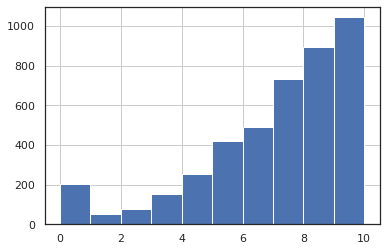

In [13]:
cened12[cened12['ETH'] < 10].ETH.hist()

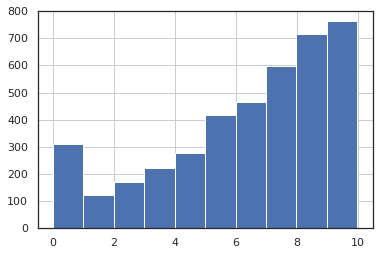

In [15]:
cened20[cened20['EP_H_ND'] < 10].EP_H_ND.hist()

## Pre-processing

In [16]:
cened20['EP_GL_NREN'].fillna(0, inplace=True)
cened20['EP_GL_REN'].fillna(0, inplace=True)

# Drop NaN 
cened20 = cened20.dropna()
cened12 = cened12.dropna() 

In [17]:
# Only entire buildings
# cened20 = cened20[cened20['INTERO_EDIFICIO'] == True]

In [18]:
# Drop renovations
cened20 = cened20[cened20['RISTRUTTURAZIONE_IMPORTANTE'] == False]
cened20 = cened20[cened20['RIQUALIFICAZIONE_ENERGETICA'] == False]

In [19]:
cened20.ANNO_COSTRUZIONE = cened20.ANNO_COSTRUZIONE.astype(str)
cened20.ANNO_COSTRUZIONE = cened20.ANNO_COSTRUZIONE.map(lambda x:x[-4:])
cened20.ANNO_COSTRUZIONE = cened20.ANNO_COSTRUZIONE.astype(int)

cened20['PERIODO_20'] = pd.cut(cened20.ANNO_COSTRUZIONE, bins=[0,1930,1945,1960,1976,1992,2006,3000],
     labels=['Before 1930','1930-1945','1946-1960','1961-1976', '1977-1992', '1993-2006','After 2006']).cat.codes

In [20]:
cened12.ANNO_COSTRUZIONE = cened12.ANNO_COSTRUZIONE.astype(str)
cened12.ANNO_COSTRUZIONE = cened12.ANNO_COSTRUZIONE.map(lambda x:x[-4:])
cened12.ANNO_COSTRUZIONE = cened12.ANNO_COSTRUZIONE.astype(int)

cened12['PERIODO_12'] = pd.cut(cened12.ANNO_COSTRUZIONE, bins=[0,1930,1945,1960,1976,1992,2006,3000],
     labels=['Before 1930','1930-1945','1946-1960','1961-1976', '1977-1992', '1993-2006','After 2006']).cat.codes

## Merge

In [21]:
# Take care of city names
cened12['COMUNE'] = cened12['COMUNE'].str.lower()
cened12['COMUNE'] = cened12['COMUNE'].str.replace(r"o`",  "o'")
cened12['COMUNE'] = cened12['COMUNE'].str.replace(r"baranzate",  "bollate")
cened12['COMUNE'] = cened12['COMUNE'].str.replace(r"bovisio masciago",  "bovisio-masciago")
cened12['COMUNE'] = cened12['COMUNE'].str.replace(r"cornate d`adda",  "cornate d'adda")
cened12['COMUNE'] = cened12['COMUNE'].str.replace(r"cortenuova",  "cortenova")
cened12['COMUNE'] = cened12['COMUNE'].str.replace(r"sant'omobono terme",  "sant'omobono imagna")

cened20['COMUNE'] = cened20['COMUNE'].str.lower()
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"`",  "'")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"o`",  "o'")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"baranzate",  "bollate")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"bovisio masciago",  "bovisio-masciago")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"cornate d`adda",  "cornate d'adda")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"cortenuova",  "cortenova")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"sant'omobono terme",  "sant'omobono imagna")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"borgo virgilio",  "virgilio")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r" - ",  "-")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"cassina de pecchi",  "cassina de' pecchi")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"cerano intelvi",  "cerano d'intelvi")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"colverde",  "drezzo")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"cornale e bastida",  "cornale")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"corteolona e genzone",  "corteolona")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"costa serina",  "costa di serina")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"gabbioneta binanuova",  "gabbioneta-binanuova")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"gadesco pieve delmona",  "gadesco-pieve delmona")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"gerre de'caprioli",  "gerre de' caprioli")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"gravedona ed uniti",  "grandola ed uniti")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"la valletta brianza",  "perego")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"lonato del garda",  "lonato")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"maccagno con pino e veddasca",  "maccagno")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"ramponio vernia",  "ramponio verna")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"sermide e felonica",  "sermide")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"toscolano maderno",  "toscolano-maderno")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"tremezzina",  "tremezzo")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"val brembilla",  "brembilla")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"verderio",  "verderio inferiore")

In [22]:
exall12 = cened12['SUBALTERNO'].str.extractall('(\d+)').fillna(0)
cened12 = exall12.join(cened12.reindex(exall12.index, level=0)).reset_index()
cened12['SUBALTERNO'] = cened12[0]

exall20 = cened20['SUBALTERNO'].str.extractall('(\d+)').fillna(0)
cened20 = exall20.join(cened20.reindex(exall20.index, level=0)).reset_index()
cened20['SUBALTERNO'] = cened20[0]

In [23]:
# Merge dfs
cenedtot = pd.merge(left=cened20, right=cened12, left_on=['COMUNE','FOGLIO', 'PARTICELLA', 'SUBALTERNO'], #, 'PERIODO' 
                    right_on=['COMUNE','FOGLIO', 'PARTICELLA', 'SUBALTERNO'],  how='inner') # , 'SUBALTERNO' | , 'SUBALTERNO'

In [24]:
print(len(cenedtot))

21611


## Pre-filtering

In [25]:
# Compute difference between ext surfaces
# cenedtot['surfdiff'] = abs((cenedtot['SUPERF_UTILE_RISCALDATA'] - cenedtot['SUPERFICIE_NETTA'])/cenedtot['SUPERF_UTILE_RISCALDATA'])

# Drop rows with high difference
#cenedtot = cenedtot[cenedtot['surfdiff'] < 0.25]

# Compute difference between ext surfaces
#cenedtot['surfdiff'] = abs((cenedtot['SUPERFICIE_DISPERDENTE_y'] - cenedtot['SUPERFICIE_DISPERDENTE_x'])/cenedtot['SUPERFICIE_DISPERDENTE_y'])

# Drop rows with high difference
#cenedtot = cenedtot[cenedtot['surfdiff'] < 0.25]

In [26]:
# Compute difference between EPH
cenedtot['ephdiff'] = abs((cenedtot['ETH'] - cenedtot['EP_H_ND'])/cenedtot['ETH'])

# Drop rows with high difference
cenedtot = cenedtot[cenedtot['ephdiff'] < 0.10]

In [27]:
cenedtot['DESTINAZIONE_DI_USO'] = cenedtot['DESTINAZIONE_DI_USO'].str.replace(r'E.1 (1)', 'E.1(1)')
cenedtot = cenedtot[cenedtot['DESTINAZIONE_DI_USO'] == 'E.1(1)']
# cenedtot = cenedtot[cenedtot['DESTINAZIONE_DI_USO'].str.contains('|'.join(['E.1', 'E.2']))]

In [28]:
cenedtot = cenedtot.dropna() 

In [29]:
cenedtot = cenedtot.drop(['SUBALTERNO', '0_x', 'match_x', 'level_0_x', 'level_0_y',	'match_y',	'0_y'], axis = 1).drop_duplicates()

In [30]:
print(len(cenedtot))

2130


# Preprocessing

In [31]:
cenedtot['SUPERFICIE_DISPERDENTE'] = (cenedtot['SUPERFICIE_DISPERDENTE_x'] + cenedtot['SUPERFICIE_DISPERDENTE_y'])/2

In [32]:
# Correct floats
for col in ['SUPERF_UTILE_RISCALDATA',
           'VOLUME_LORDO_RISCALDATO', 'SUPERFICIE_DISPERDENTE',
           'RAPPORTO_SV','A_SOL_EST_A_SUP_UTILE','Y_IE','EP_H_ND','EP_GL_NREN','EP_GL_REN']:
    cenedtot[col] = cenedtot[col].astype(str)
    cenedtot[col] = cenedtot[col].str.replace(r',', '')
    cenedtot[col] = cenedtot[col].astype("float")

In [33]:
# Take care of ach
cenedtot.NUMERO_RICAMBI_ORARI = cenedtot.NUMERO_RICAMBI_ORARI.astype(str)
cenedtot.NUMERO_RICAMBI_ORARI = cenedtot.NUMERO_RICAMBI_ORARI.map(lambda x:x[:6])
cenedtot.NUMERO_RICAMBI_ORARI = cenedtot.NUMERO_RICAMBI_ORARI.astype(float)

#Feature engineering

In [34]:
# Add ddh
ddh['comune'] = ddh['comune'].str.lower()
ddh['comune'] = ddh['comune'].str.replace(r"è",  "e'")
ddh['comune'] = ddh['comune'].str.replace(r"è",  "e'")
ddh['comune'] = ddh['comune'].str.replace(r"é",  "e'")
ddh['comune'] = ddh['comune'].str.replace(r"ò",  "o'")
ddh['comune'] = ddh['comune'].str.replace(r"ù",  "u'")

cenedtot = cenedtot.merge(ddh, left_on='COMUNE', right_on='comune', how='left')

In [35]:
# Opaque surface
cenedtot['SUP_OPACA'] = cenedtot['SUPERFICIE_DISPERDENTE']/(1+cenedtot['SUPERFICIE_VETRATA_OPACA'])

# Glazing
cenedtot['SUP_FINESTRATA'] = cenedtot['SUPERFICIE_DISPERDENTE'] - cenedtot['SUP_OPACA']

In [36]:
cenedtot['ALTEZZA_MEDIA_12'] = cenedtot['VOLUME_NETTO']/cenedtot['SUPERFICIE_NETTA']
cenedtot['ALTEZZA_MEDIA_20'] = cenedtot['VOLUME_LORDO_RISCALDATO']/cenedtot['SUPERF_UTILE_RISCALDATA']

In [37]:
cenedtot['TRASMITTANZA_MEDIA'] = (cenedtot['TRASMITTANZA_MEDIA_SERRAMENTO'] + cenedtot['TRASMITTANZA_MEDIA_COPERTURA'] +
         cenedtot['TRASMITTANZA_MEDIA_BASAMENTO'] + cenedtot['TRASMITTANZA_MEDIA_INVOLUCRO'])/4

In [38]:
cenedtot['EP_GL_TOT'] = cenedtot['EP_GL_REN'] + cenedtot['EP_GL_NREN']

In [39]:
# East facing surface
cenedtot['A_SOL_EST'] = cenedtot['A_SOL_EST_A_SUP_UTILE']*cenedtot['SUPERF_UTILE_RISCALDATA']

#Filters

In [40]:
for col in ['TRASMITTANZA_MEDIA_COPERTURA','TRASMITTANZA_MEDIA_INVOLUCRO',
          'TRASMITTANZA_MEDIA_BASAMENTO','TRASMITTANZA_MEDIA_SERRAMENTO']:
          cenedtot = cenedtot[cenedtot[col].between(0,6, inclusive=False)]

cenedtot = cenedtot[cenedtot['TRASMITTANZA_MEDIA'] > 0.15]
cenedtot = cenedtot[cenedtot['TRASMITTANZA_MEDIA'] < 4]

cenedtot = cenedtot[cenedtot['Y_IE'] <= 6]
cenedtot = cenedtot[cenedtot['Y_IE'] >= 0.01]

In [41]:
# Drop buildings with wrong An
cenedtot = cenedtot[cenedtot['SUPERFICIE_NETTA'] >= 50]
cenedtot = cenedtot[cenedtot['SUPERF_UTILE_RISCALDATA'] >= 50]

# Drop buildings with wrong Vn
cenedtot = cenedtot[cenedtot['VOLUME_NETTO'] > 150]
cenedtot = cenedtot[cenedtot['VOLUME_LORDO_RISCALDATO'] >= 150]

In [42]:
# Glazed surface
cenedtot = cenedtot[cenedtot['SUP_FINESTRATA'] > 1]

# Glazing ratio
cenedtot = cenedtot[cenedtot['SUPERFICIE_VETRATA_OPACA'] > 0]
cenedtot = cenedtot[cenedtot['SUPERFICIE_VETRATA_OPACA'] < 0.9]

In [43]:
cenedtot = cenedtot[cenedtot['ALTEZZA_MEDIA_12'] > 2.4]
cenedtot = cenedtot[cenedtot['ALTEZZA_MEDIA_20'] > 2.4]

In [44]:
# Drop buildings with wrong EPH
cenedtot = cenedtot[cenedtot['EP_H_ND'] > 5]
cenedtot = cenedtot[cenedtot['EP_H_ND'] < 1000]

In [45]:
cenedtot = cenedtot[cenedtot['A_SOL_EST_A_SUP_UTILE'] <= 0.5]
cenedtot = cenedtot[cenedtot['A_SOL_EST_A_SUP_UTILE'] > 0]

In [46]:
len(cenedtot)

1460

# Data analysis

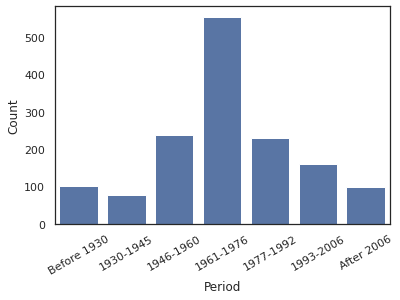

In [47]:
# Period
fig = plt.figure(figsize = (6,4))
cplot = sns.countplot(x = pd.cut(cenedtot.ANNO_COSTRUZIONE_x, bins=[0,1930,1945,1960,1976,1992,2006,3000], 
       labels=['Before 1930','1930-1945','1946-1960','1961-1976', '1977-1992', 
               '1993-2006','After 2006']), color = 'b')
cplot.set(ylabel = 'Count', xlabel = 'Period')
plt.xticks(rotation=30)
plt.show()

# Shuffle

In [48]:
cened = cenedtot.sample(frac=1, random_state = 42).reset_index(drop=True)

# Reserve a test set

In [49]:
msk = np.random.rand(len(cened)) < 0.8
train = cened[msk]
test = cened[~msk]

In [50]:
print(len(train))

1179


In [51]:
print(len(test))

281


# Define MAPE

In [52]:
def neg_mape(y_true, y_pred):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  return -np.abs((y_true - y_pred)/y_true).mean()

In [53]:
def modified_neg_mape(y_true, y_pred):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  errors = np.abs((y_true - y_pred)/y_true)
  index = np.argwhere(errors > 1)
  mod_errors = np.delete(errors, index)
  return -mod_errors.mean()

In [54]:
neg_mape_scorer = make_scorer(neg_mape, greater_is_better=True)

In [55]:
modified_neg_mape_scorer = make_scorer(modified_neg_mape, greater_is_better=True)

# 2.0 inputs

## Random search

In [156]:
mlcol = ['SUPERF_UTILE_RISCALDATA',
           'VOLUME_LORDO_RISCALDATO',
           'SUPERFICIE_DISPERDENTE_x', 'dd','PERIODO_20',
           'RAPPORTO_SV','A_SOL_EST_A_SUP_UTILE','Y_IE',
           'ALTEZZA_MEDIA_20', 'A_SOL_EST', 'NUMERO_UNITA_IMMOBILIARI']

In [157]:
cat_feats = ['PERIODO_20']

In [158]:
param_dist = {'feature_fraction': np.linspace(0.4, 1, num=7),
              'num_leaf' : list(range(20,40)),
             'max_depth' : [-1],
             'max_bin' : [100, 200, 300, 500, 750, 1000, 2000],
             'bagging_fraction' : np.linspace(0.4, 1, num=14),
             'bagging_freq' : list(range(1,10)),
             'lambda_l1' : stats.uniform(0, 0.6),
             'lambda_l2' : stats.uniform(0, 0.6)}

lgbm20 = LGBMRegressor(n_estimators = 200, silent = True, verbose = 0, is_training_metric = True, n_jobs = 1, 
                     eval_metric  = 'mape')

n_iter_search = 100

random_search20 = RandomizedSearchCV(lgbm20, param_distributions=param_dist, n_iter=n_iter_search, 
                                   scoring={'MAPE' : neg_mape_scorer, 'MAPE <100%' : modified_neg_mape_scorer, 'R2' : 'r2'} , cv = 5, n_jobs = 6, verbose = 2, refit = 'MAPE',
                                   random_state=42)

random_search20.fit(cened[mlcol], cened['EP_H_ND'], categorical_feature = cat_feats)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   11.3s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:   37.1s
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 500 out of 500 | elapsed:  1.9min finished
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PERIODO_20']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           eval_metric='mape',
                                           importance_type='split',
                                           is_training_metric=True,
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=200,
                                           n_jobs=1, num_leaves=31,
                                           objective=None, random_sta...
                                        'lambda_l2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f01226aec18>,
            

## Print results

In [159]:
print(random_search20.best_params_)

{'bagging_fraction': 0.8615384615384616, 'bagging_freq': 5, 'feature_fraction': 0.7, 'lambda_l1': 0.23166158268046455, 'lambda_l2': 0.5767143382943485, 'max_bin': 200, 'max_depth': -1, 'num_leaf': 30}


In [160]:
print(random_search20.best_score_)

-0.23118982533189172


In [161]:
# Create a results df
cv_df20 = pd.DataFrame(random_search20.cv_results_)
cv_df20 = cv_df20.sort_values(by = ['rank_test_MAPE']).reset_index()

# Filter columns
res_cols20 = [col for col in cv_df20 if col.startswith('split')]

# Select best iter
best_res20 = cv_df20.loc[0]

# Print results for each fold
print(best_res20[res_cols20])

split0_test_MAPE         -0.231552
split1_test_MAPE         -0.252162
split2_test_MAPE         -0.214379
split3_test_MAPE         -0.226963
split4_test_MAPE         -0.230893
split0_test_MAPE <100%   -0.201944
split1_test_MAPE <100%   -0.201757
split2_test_MAPE <100%   -0.195427
split3_test_MAPE <100%   -0.205338
split4_test_MAPE <100%   -0.200995
split0_test_R2            0.644434
split1_test_R2            0.610502
split2_test_R2            0.657852
split3_test_R2             0.63594
split4_test_R2             0.68191
Name: 0, dtype: object


In [200]:
# Best R2
print(best_res20.mean_test_R2)

0.6461275685213309


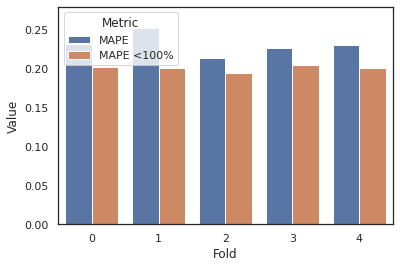

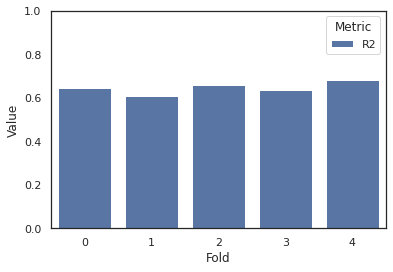

In [162]:
df20 = pd.DataFrame(best_res20[res_cols20])
df20 = df20.rename(columns = {0:'Value'})
df20['Fold'] = df20.index.str[5:6]
df20['Metric'] = df20.index.str[12:]
df20['Value'] = np.where(df20['Metric'] == 'R2', df20['Value'], df20['Value'] * -1)
ax = sns.barplot(x='Fold', y="Value", hue="Metric", data = df20[df20['Metric'] != 'R2'])
ax.set(ylim = (0, 0.28))
plt.show()
ax = sns.barplot(x='Fold', y="Value", hue="Metric", data = df20[df20['Metric'] == 'R2'])
ax.set(ylim = (0, 1))
plt.show()

## Train the final model

In [163]:
light20 = LGBMRegressor(n_estimators = 1000, silent = False, verbose = 2, is_training_metric = True, n_jobs = 6)
light20.set_params(**random_search20.best_params_)

LGBMRegressor(bagging_fraction=0.8615384615384616, bagging_freq=5,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.7, importance_type='split',
              is_training_metric=True, lambda_l1=0.23166158268046455,
              lambda_l2=0.5767143382943485, learning_rate=0.1, max_bin=200,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=1000, n_jobs=6, num_leaf=30,
              num_leaves=31, objective=None, random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=False, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbose=2)

In [164]:
light20.fit(train[mlcol], train['EP_H_ND'])

LGBMRegressor(bagging_fraction=0.8615384615384616, bagging_freq=5,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.7, importance_type='split',
              is_training_metric=True, lambda_l1=0.23166158268046455,
              lambda_l2=0.5767143382943485, learning_rate=0.1, max_bin=200,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=1000, n_jobs=6, num_leaf=30,
              num_leaves=31, objective=None, random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=False, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbose=2)

## Test the model

In [165]:
y_pred20 = light20.predict(test[mlcol]).clip(0)

In [166]:
results_df20 = pd.DataFrame({'predicted' : y_pred20, 'true' : test['EP_H_ND']})
results_df20['error'] = np.abs((results_df20['true'] - results_df20['predicted'])/results_df20['true'])*100

In [167]:
# MAPE
results_df20['error'].mean()

21.001301105094225

In [168]:
# Max % error
results_df20['error'].max()

180.4555276988449

In [169]:
# Row with the highest % error
results_df20.iloc[results_df20['error'].argmax()]

predicted    173.910473
true          62.010000
error        180.455528
Name: 1053, dtype: float64

In [170]:
# MAPE without >100%
results_df20[results_df20.error <= 100].error.mean()

19.19593204337952

In [171]:
# R2 
print(r2_score(test['EP_H_ND'], y_pred20))

0.6130838503432736


In [172]:
# R2 without >100%
print(r2_score(results_df20[results_df20.error <= 100].true, results_df20[results_df20.error <= 100].predicted))

0.6300361063102587


In [173]:
results_df20

,predicted,true,error
0,157.370179,173.32,9.202528
1,190.480759,180.76,5.377716
2,53.452774,31.52,69.583673
7,97.316407,120.98,19.559922
11,123.231161,100.98,22.035216
...,...,...,...
1436,167.027596,241.98,30.974628
1438,148.525216,112.64,31.858324
1448,167.890221,129.18,29.966110
1455,157.559712,163.05,3.367242


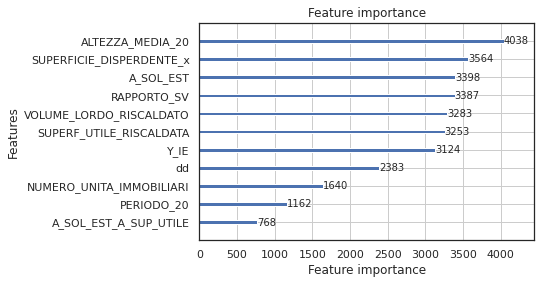

In [174]:
plot_importance(light20)

## Error analysis

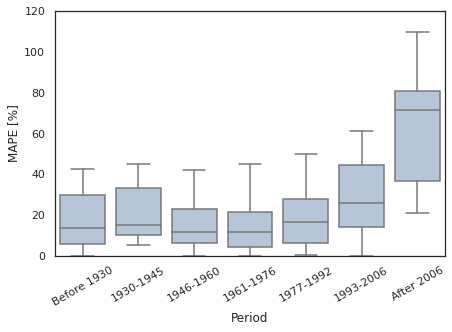

In [214]:
# Period
bins = pd.cut(test.ANNO_COSTRUZIONE_x, bins=[0,1930,1945,1960,1976,1992,2006,3000], 
       labels=['Before 1930','1930-1945','1946-1960','1961-1976', '1977-1992', 
               '1993-2006','After 2006'])

fig = plt.figure(figsize = (7, 4.5))
box = sns.boxplot(y = results_df20.error, x = bins, 
                  color='lightsteelblue', orient = 'v', 
                  showfliers = False)

box.set(ylim = (0, 120), ylabel = 'MAPE [%]', xlabel = 'Period')
plt.xticks(rotation=30)
plt.show()

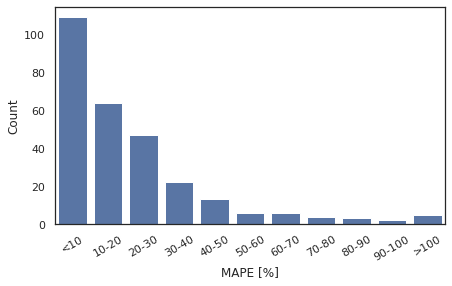

In [212]:
# Error
fig = plt.figure(figsize = (7,4))
cplot = sns.countplot(x = pd.cut(results_df20.error, bins=[0,10,20,30,40,50,60,70,80,90,100,10000],
                                 labels = ['<10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '>100']), color = 'b')
cplot.set(ylabel = 'Count', xlabel = 'MAPE [%]')
plt.xticks(rotation=30)
plt.show()

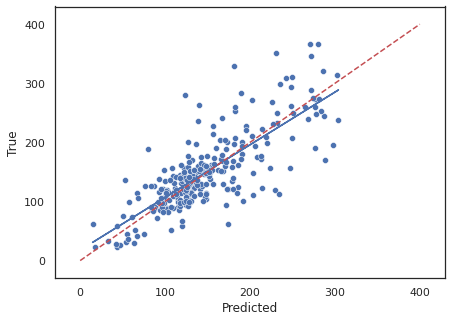

In [210]:
# Scatterplot
fig = plt.figure(figsize = (7,5))
scatter = sns.scatterplot(data=results_df20, x="predicted", y="true")
scatter.set(ylabel = 'True', xlabel = 'Predicted',
            xlim=(-30, 430), ylim=(-30, 430))
m, b = np.polyfit(results_df20['predicted'], results_df20['true'], 1)
plt.plot(results_df20['predicted'].values, m*results_df20['predicted'] + b)
plt.plot([0, 400], [0,400], c = 'r', linestyle='--')
plt.show()

# 1.2 inputs

## Random search

In [178]:
mlcol = ['PERIODO_20', 'SUPERFICIE_LORDA', 'SUPERFICIE_NETTA',
           'VOLUME_LORDO', 
         'VOLUME_NETTO', 'SUPERFICIE_DISPERDENTE_x',
         'TRASMITTANZA_MEDIA_INVOLUCRO', 'TRASMITTANZA_MEDIA_COPERTURA',
         'TRASMITTANZA_MEDIA_BASAMENTO', 'TRASMITTANZA_MEDIA_SERRAMENTO',
         'dd','SUP_FINESTRATA','SUP_OPACA', 'SUPERFICIE_VETRATA_OPACA',
         'NUMERO_RICAMBI_ORARI', 'ALTEZZA_MEDIA_12'] # 'SUPERF_UTILE_RISCALDATA', 'VOLUME_LORDO_RISCALDATO', 

In [179]:
cat_feats = ['PERIODO_20']

In [180]:
param_dist = {'feature_fraction': np.linspace(0.4, 1, num=7),
              'num_leaf' : list(range(20,40)),
             'max_depth' : [-1],
             'max_bin' : [100, 200, 300, 500, 750, 1000, 2000],
             'bagging_fraction' : np.linspace(0.4, 1, num=14),
             'bagging_freq' : list(range(1,10)),
             'lambda_l1' : stats.uniform(0, 0.6),
             'lambda_l2' : stats.uniform(0, 0.6)}

lgbm = LGBMRegressor(n_estimators = 200, silent = True, verbose = 0, is_training_metric = True, n_jobs = 1, 
                     eval_metric  = 'mape')

n_iter_search = 100

random_search = RandomizedSearchCV(lgbm, param_distributions=param_dist, n_iter=n_iter_search, 
                                   scoring={'MAPE' : neg_mape_scorer, 'MAPE <100%' : modified_neg_mape_scorer, 'R2' : 'r2'} , cv = 5, n_jobs = 6, verbose = 2, refit = 'MAPE',
                                   random_state=42)

random_search.fit(cened[mlcol], cened['EP_H_ND'], categorical_feature = cat_feats)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   11.7s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:   52.9s
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 500 out of 500 | elapsed:  2.9min finished
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PERIODO_20']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           eval_metric='mape',
                                           importance_type='split',
                                           is_training_metric=True,
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=200,
                                           n_jobs=1, num_leaves=31,
                                           objective=None, random_sta...
                                        'lambda_l2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0122030438>,
            

## Print results

In [181]:
print(random_search.best_params_)

{'bagging_fraction': 0.8153846153846154, 'bagging_freq': 7, 'feature_fraction': 0.5, 'lambda_l1': 0.06952143571507782, 'lambda_l2': 0.5178620555253561, 'max_bin': 500, 'max_depth': -1, 'num_leaf': 21}


In [182]:
print(random_search.best_score_)

-0.1360555928943251


In [183]:
# Create a results df
cv_df = pd.DataFrame(random_search.cv_results_)
cv_df = cv_df.sort_values(by = ['rank_test_MAPE']).reset_index()

# Filter columns
res_cols = [col for col in cv_df if col.startswith('split')]

# Select best iter
best_res = cv_df.loc[0]

# Print results for each fold
print(best_res[res_cols])

split0_test_MAPE         -0.126611
split1_test_MAPE         -0.143828
split2_test_MAPE          -0.14835
split3_test_MAPE         -0.123834
split4_test_MAPE         -0.137656
split0_test_MAPE <100%   -0.126611
split1_test_MAPE <100%    -0.13304
split2_test_MAPE <100%   -0.136998
split3_test_MAPE <100%   -0.120642
split4_test_MAPE <100%   -0.133919
split0_test_R2            0.857208
split1_test_R2            0.819083
split2_test_R2            0.852534
split3_test_R2            0.837872
split4_test_R2            0.828398
Name: 0, dtype: object


In [202]:
# Best R2
print(best_res.mean_test_R2)

0.8390190673045848


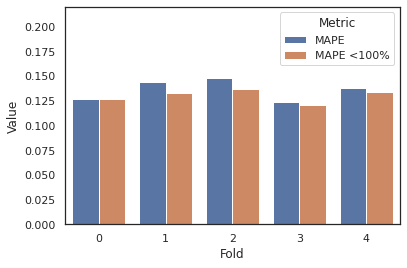

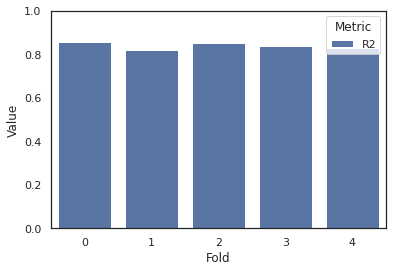

In [184]:
df = pd.DataFrame(best_res[res_cols])
df = df.rename(columns = {0:'Value'})
df['Fold'] = df.index.str[5:6]
df['Metric'] = df.index.str[12:]
df['Value'] = np.where(df['Metric'] == 'R2', df['Value'], df['Value'] * -1)
ax = sns.barplot(x='Fold', y="Value", hue="Metric", data = df[df['Metric'] != 'R2'])
ax.set(ylim = (0, 0.22))
plt.show()
ax = sns.barplot(x='Fold', y="Value", hue="Metric", data = df[df['Metric'] == 'R2'])
ax.set(ylim = (0, 1))
plt.show()

## Train the final model

In [185]:
light = LGBMRegressor(n_estimators = 1000, silent = False, verbose = 2, is_training_metric = True, n_jobs = 6)
light.set_params(**random_search.best_params_)

LGBMRegressor(bagging_fraction=0.8153846153846154, bagging_freq=7,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.5, importance_type='split',
              is_training_metric=True, lambda_l1=0.06952143571507782,
              lambda_l2=0.5178620555253561, learning_rate=0.1, max_bin=500,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=1000, n_jobs=6, num_leaf=21,
              num_leaves=31, objective=None, random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=False, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbose=2)

In [186]:
light.fit(train[mlcol], train['EP_H_ND'])

LGBMRegressor(bagging_fraction=0.8153846153846154, bagging_freq=7,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.5, importance_type='split',
              is_training_metric=True, lambda_l1=0.06952143571507782,
              lambda_l2=0.5178620555253561, learning_rate=0.1, max_bin=500,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=1000, n_jobs=6, num_leaf=21,
              num_leaves=31, objective=None, random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=False, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbose=2)

## Test the model

In [187]:
y_pred = light.predict(test[mlcol]).clip(0)

In [188]:
results_df = pd.DataFrame({'predicted' : y_pred, 'true' : test['EP_H_ND']})
results_df['error'] = np.abs((results_df['true'] - results_df['predicted'])/results_df['true'])*100

In [189]:
# MAPE
results_df['error'].mean()

11.51604108996712

In [190]:
# Max % error
results_df['error'].max()

75.70117671942498

In [191]:
# Row with the highest % error
results_df.iloc[results_df['error'].argmax()]

predicted    182.694084
true         103.980000
error         75.701177
Name: 314, dtype: float64

In [192]:
# MAPE without >100%
results_df[results_df.error <= 100].error.mean()

11.51604108996712

In [193]:
# R2 
print(r2_score(test['EP_H_ND'], y_pred))

0.8090732136933049


In [194]:
# R2 without >100%
print(r2_score(results_df[results_df.error <= 100].true, results_df[results_df.error <= 100].predicted))

0.8090732136933049


In [195]:
results_df

,predicted,true,error
0,172.726957,173.32,0.342166
1,194.280717,180.76,7.479927
2,37.994071,31.52,20.539564
7,122.416701,120.98,1.187552
11,112.942134,100.98,11.846043
...,...,...,...
1436,211.439577,241.98,12.621052
1438,116.675330,112.64,3.582502
1448,141.107373,129.18,9.233142
1455,161.245403,163.05,1.106775


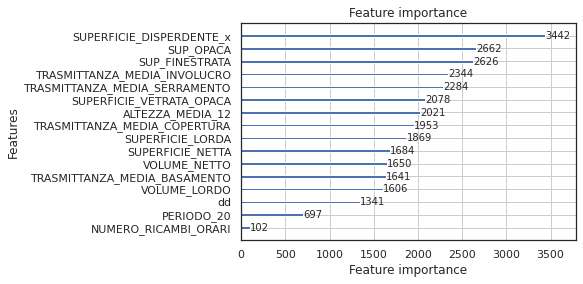

In [196]:
plot_importance(light)

## Error analysis

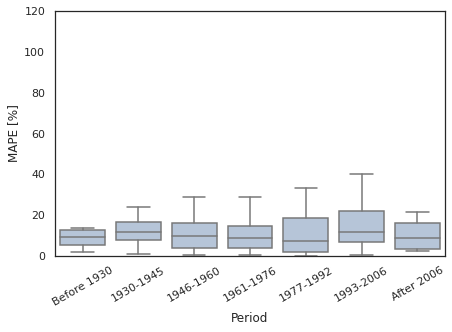

In [215]:
# Period
bins = pd.cut(test.ANNO_COSTRUZIONE_x, bins=[0,1930,1945,1960,1976,1992,2006,3000], 
       labels=['Before 1930','1930-1945','1946-1960','1961-1976', '1977-1992', 
               '1993-2006','After 2006'])

fig = plt.figure(figsize = (7, 4.5))
box = sns.boxplot(y = results_df.error, x = bins, 
                  color='lightsteelblue', orient = 'v', 
                  showfliers = False)

box.set(ylim = (0, 120), ylabel = 'MAPE [%]', xlabel = 'Period')
plt.xticks(rotation=30)
plt.show()

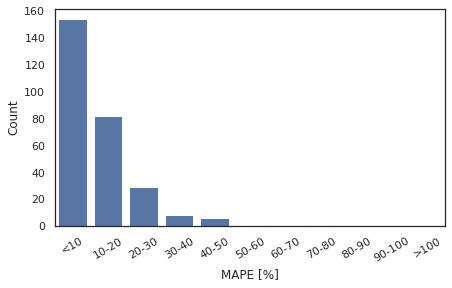

In [211]:
# Error
fig = plt.figure(figsize = (7,4))
cplot = sns.countplot(x = pd.cut(results_df.error, bins=[0,10,20,30,40,50,60,70,80,90,100,10000],
                                 labels = ['<10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '>100']), color = 'b')
cplot.set(ylabel = 'Count', xlabel = 'MAPE [%]')
plt.xticks(rotation=30)
plt.show()

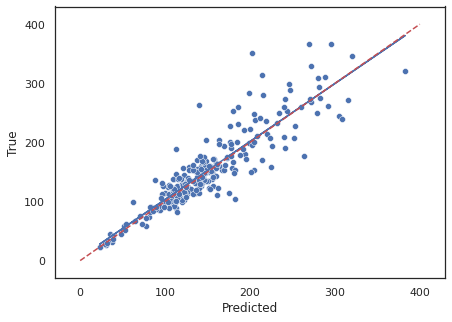

In [209]:
# Scatterplot
fig = plt.figure(figsize = (7,5))
scatter = sns.scatterplot(data=results_df, x="predicted", y="true")
scatter.set(ylabel = 'True', xlabel = 'Predicted',
            xlim=(-30, 430), ylim=(-30, 430))
m, b = np.polyfit(results_df['predicted'], results_df['true'], 1)
plt.plot(results_df['predicted'].values, m*results_df['predicted'] + b)
plt.plot([0, 400], [0,400], c = 'r', linestyle='--')
plt.show()